Research topic: Crash analysis for taxi vehicles per total number of trips in 2019 in each borough. Analyse what are the common factors that are causing the crashes; predict the number, injuries/fatalities, and the contributing factor(s) for future crashes; and inform taxi drivers of these findings to significantly reduce the number of crashes in the future.

Factors include: what causes the crash (improper turning, running the red, following too closely, etc), location (borough) (probably a pain in the ass to match with lat/lon), time (day vs night, peak hour vs empty streets), weather (probably not gonna be used because the hourly data too complicated, massive, and hard to get)

Plan:
- Granularise time into two features: day and night, and the day is further split into peak and non-peak hours
- day and night in this scenario is not determined by sunset and sunrise times, but by the time when civil twilight ends (why?)
- Need to take into account weekends and public holidays: in this case, they will be calculated separately
- 

External datasets: https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD  <- crash data (download link)
    https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/data   <- crash data
    https://dateandtime.info/citysunrisesunset.php?id=5128581&month=1&year=2019                  <- sunrise/sunset data to separate night and day
    https://github.com/akiratwang/MAST30034_Python/blob/main/data/taxi_zones/                    <- taxi zones data
    https://www1.nyc.gov/assets/opa/downloads/pdf/2019-list-of-holidays.pdf                      <- NYC public holiday data

references:
- https://medium.com/analytics-vidhya/how-to-scrape-a-table-from-website-using-python-ce90d0cfb607 <- web scraping

In [1]:
# read data
import pandas as pd

crime = pd.read_csv("../data/curated/crime.csv")

## The distribution of the response variable

(array([1.7326e+04, 5.3470e+03, 2.6110e+03, 1.5450e+03, 9.9300e+02,
        6.5500e+02, 4.2700e+02, 2.9700e+02, 2.2400e+02, 1.8300e+02,
        1.5600e+02, 1.3100e+02, 1.2500e+02, 1.0500e+02, 9.4000e+01,
        7.8000e+01, 8.2000e+01, 6.3000e+01, 7.1000e+01, 5.3000e+01,
        4.8000e+01, 3.3000e+01, 3.1000e+01, 1.8000e+01, 2.1000e+01,
        1.3000e+01, 7.0000e+00, 8.0000e+00, 3.0000e+00, 3.0000e+00,
        4.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 <BarContainer object of 36 artists>)

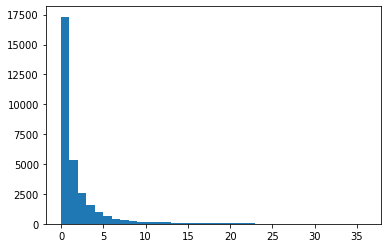

In [2]:
import numpy as np
import matplotlib.pyplot as plt

y = crime["count"]
plt.hist(y, bins=[i for i in range(max(crime["count"]) + 1)])

Based on the histogram, the data is not normally distributed. It could be negative binomial or poisson...?

Anyway, the point is, any type of linear model is definitely not applicable here, and I'm not doing negative binomial nor poisson regression because that is out of the scope of my knowledge.


In [121]:
# apply one hot encoding to transform nominal variable 
# and ordinal encoding to transform ordinal variable
X = crime.drop(columns=["date", "count"])

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

ohe = OneHotEncoder()
oe = OrdinalEncoder(categories=[["normal", "fast", "empty"]])

ohe.fit_transform(X[["season", "daylight", "borough"]])
oe.fit_transform(X[["speed"]])

X_t = make_column_transformer((ohe, ["season", "daylight", "borough"]), \
    (oe, ["speed"]))

column_names = X_t.fit(X).get_feature_names_out()
X = X_t.fit_transform(X)

print(column_names)
print(X)

['onehotencoder__season_autumn' 'onehotencoder__season_spring'
 'onehotencoder__season_summer' 'onehotencoder__season_winter'
 'onehotencoder__daylight_day' 'onehotencoder__daylight_night'
 'onehotencoder__borough_Bronx' 'onehotencoder__borough_Brooklyn'
 'onehotencoder__borough_Manhattan' 'onehotencoder__borough_Queens'
 'onehotencoder__borough_Staten Island' 'ordinalencoder__speed']
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 1. 2.]
 [0. 0. 0. ... 0. 0. 2.]]


In [58]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.25, random_state=0)

(23073, 12)

## Dummy Regression

In [131]:
# simply predicts the value which has the most occurrence, which is 0. This will be used as the baseline.
dummy_pred = np.zeros(y_test.shape[0])

# evaluation using RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(np.sqrt(mean_squared_error(y_test, dummy_pred)))
print(np.sqrt(mean_absolute_error(y_test, dummy_pred)))

3.591027125911577
1.2430775557753373


## Poisson Regression

In [133]:
# note that although the data looks like it follows a poisson distribution,
# its variance is actually a lot larger than its mean. (Poisson has equal mean and variance)

from sklearn.linear_model import PoissonRegressor

pr = PoissonRegressor()
pr.fit(X_train, y_train)
y_pred = pr.predict(X_test)

print(np.mean(y_pred))
print(np.var(y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_absolute_error(y_test, y_pred)))

1.5589077300622127
0.5382308309744734
2.815703960985826
1.2812055376238736


In [129]:
# As seen there, although the mean of the predicted values looks fine, 
# the variance of the predicted values are way off the actual variance.
np.var(y_test)
# In addition, the RMSE, although better from the baseline model, is still barely an improvement.

10.507703568673168

Since this predicted data has higher variance than mean, the data is overdispersed. Dealing with overdispersion requires a much deeper statistical knowledge that is beyond the scope of my understanding as well as what's required in this subject. (I believe this topic is discussed in MAST30027, but that is in week 4. Given the deadline of this subject, and how much work I have to split among four subjects, I'm afraid that is not possible...not everyone has 150 IQ!)

Instead of doing regression, I will use two models that are both based on decision trees as their main components: random forest and gradient boost. They should, in theory, work better because decision trees don't depend on whether the data follows a certain distribution.

I will also use MAE and MAPE in addition to RMSE as evaluation metrics.

## Random Forest Regression

In [134]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=0)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)


print(np.mean(y_pred))
print(np.var(y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_absolute_error(y_test, y_pred)))
rfr.feature_importances_

1.5293525510353694
8.595977829190911
1.502189463616242
0.9074677142261222


array([8.79690851e-03, 2.10689650e-03, 4.26747631e-03, 1.26247754e-02,
       1.55397796e-01, 1.56329418e-01, 2.63665665e-03, 4.09930930e-04,
       2.75126553e-01, 1.92343305e-04, 3.38034704e-02, 3.48307775e-01])

## Gradient Boosting Regression

In [135]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=10)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print(np.mean(y_pred))
print(np.var(y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_absolute_error(y_test, y_pred)))
gbr.feature_importances_

1.5292763967738354
8.599750322368662
1.5022832300777793
0.9074120724568268


array([1.00249230e-02, 1.37880904e-04, 3.25445699e-03, 1.35524704e-02,
       2.19759079e-01, 9.22277789e-02, 2.42775547e-03, 4.84427652e-04,
       2.75981315e-01, 1.44763672e-04, 3.39129644e-02, 3.48092185e-01])

note note note note